# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
import doubletdetection
import tarfile
import time


/Users/jonathanshor/anaconda2/envs/Python3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Download Data from 10x

In [2]:
!curl -O http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0  5169k      0  0:00:07  0:00:07 --:--:-- 7096k


### Load Count Matrix

In [3]:
matrix_path = 'filtered_gene_bc_matrices/GRCh38/matrix.mtx'
raw_counts = doubletdetection.load_mtx(matrix_path)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]

## Run Doublet Detection

Right now, phenograph is a bit talkative, so we capture the output to avoid lots of text

In [4]:
# %%capture

clf = doubletdetection.BoostClassifier(n_iters=50)

start = time.time()
doublets = clf.fit(raw_counts).predict()
end = time.time()


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 30], with sizes: [130, 1136, 935, 920, 787, 746, 662, 541, 424, 419, 395, 313, 311, 300, 288, 264, 233, 222, 213, 196, 172, 150, 110, 108, 105, 89, 80, 69, 58, 44, 28, 28]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 29], with sizes: [121, 1154, 1039, 845, 810, 707, 686, 494, 491, 412, 367, 356, 313, 298, 297, 247, 237, 225, 210, 192, 170, 161, 143, 139, 71, 69, 65, 58, 45, 30, 24]


Creating downsampled doublets...
Normalizing...
Running PCA...
Clustering augmented data set with Phenograph...

Found communities [-1, ... 31], with sizes: [135, 1093, 1048, 872, 772, 745, 521, 435, 426, 403, 372, 339, 329, 316, 288, 238, 232, 223, 209, 198, 196, 193, 134, 123, 113, 104, 94, 92, 85, 74, 27, 26, 21]


Creating downsampled doublets...
Normalizing...
Running

In [7]:
print('Time elapsed: {:.2f} seconds, {:.2f}sec/iteration, for {} iterations'.format(end-start, (end-start) / clf.n_iters, clf.n_iters))

Time elapsed: 1530.41 seconds, 30.61sec/iteration, for 50 iterations


## Visualize Results

### Convergence of Doublet Calls

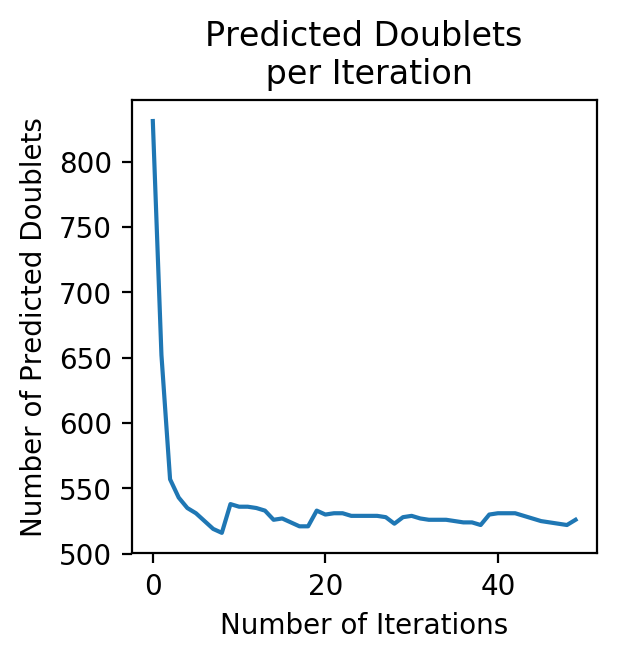

In [8]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True)

### Doublets on TSNE map

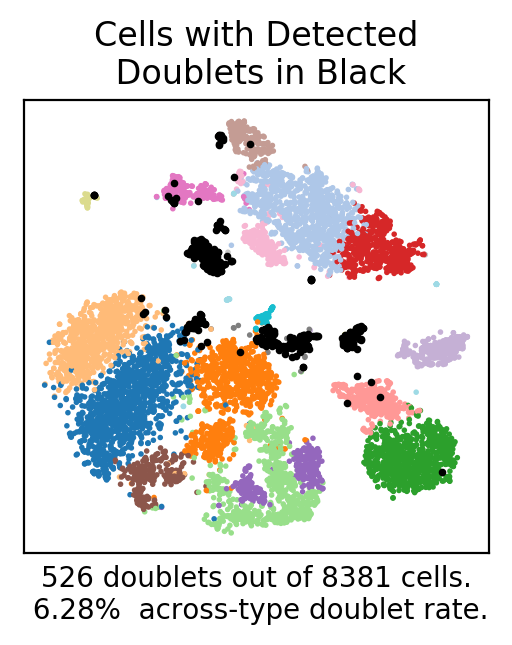

In [9]:
f2, tsne_coords = doubletdetection.plot.tsne(raw_counts, doublets, save='tsne_test.pdf', show=True)